In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy.integrate as spint
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

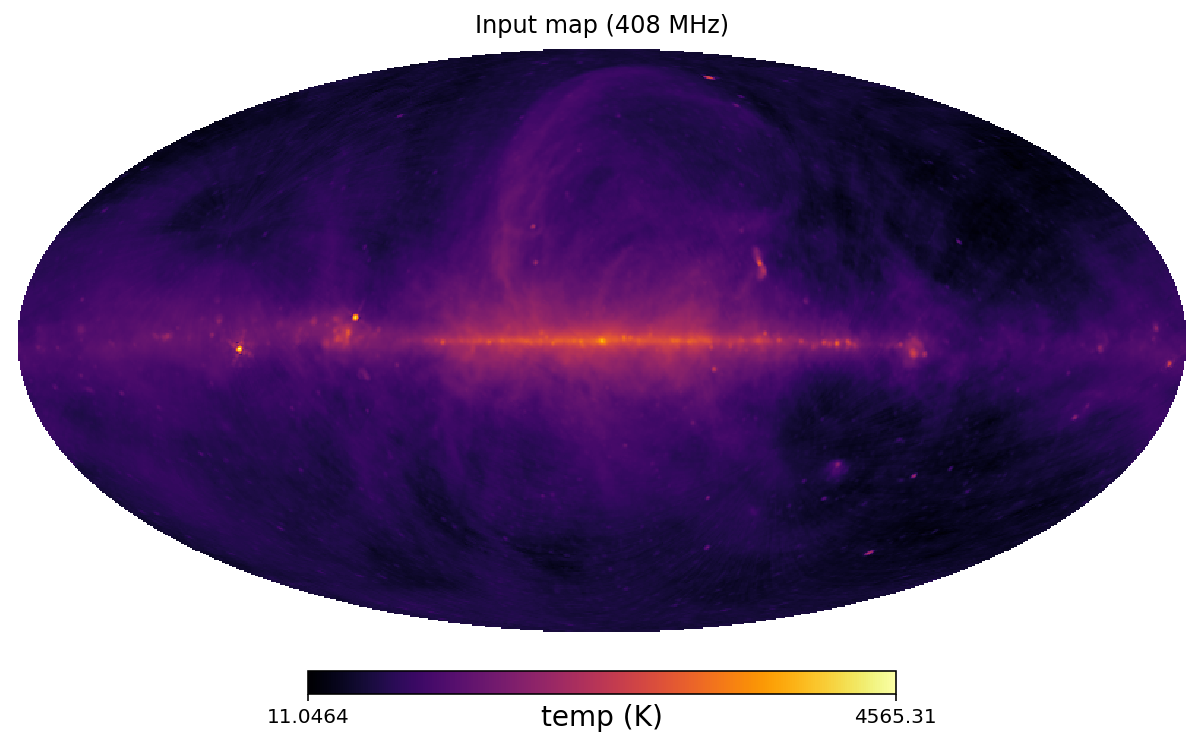

In [3]:
#loading in map data
map_raw_address = '/Users/harpersewalls/Desktop/SURA/Haslam_static_map/lambda_haslam408_nofilt.fits'
map_raw = hp.read_map(map_raw_address)/1000 #divide by 1000 to convert mK to K
hp.mollview(map_raw,norm='log',title="Input map (408 MHz)", unit='temp (K)', cmap='inferno')
#map with filtering and string sources removed


# scale this map to many frequencies in the range 50 MHz to 3 GHz

In [4]:
#function that takes the map above and scales it with the proper relation to a new frequency
def Haslam_freq_scaler(map_408, freq):
    B = 0
    new_map = np.ones(len(map_408))
    for i in range(len(map_408)):
        B = map_408[i]*(408e6**(2.5))
        new_map[i] = B/(freq**(2.5))
        B = 0
    B = 0
    return(new_map)

CPU times: user 6.13 s, sys: 30.7 ms, total: 6.16 s
Wall time: 6.16 s


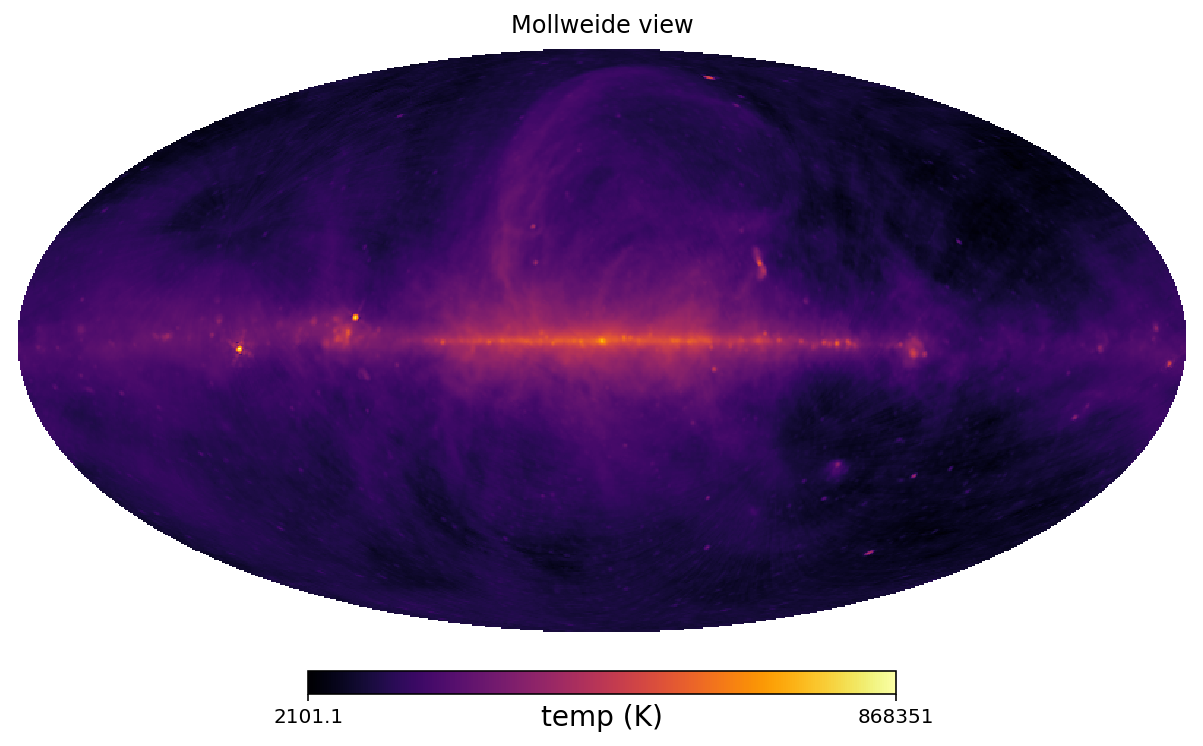

In [5]:
%%time
a = Haslam_freq_scaler(map_raw, 50e6)
hp.mollview(a, unit='temp (K)', norm='log', cmap='inferno')

In [21]:
%%time
#iterating over the frequency values for which we wish to plot S/N ratio and saving a temperature map
#for each frequency in raw_maps

freqs = np.linspace(50e6, 3e9, 50)
for i in freqs:
    temp_map = Haslam_freq_scaler(map_raw, i)
    np.savez("raw_maps/map_raw_%s_Hz"%(round(i)), temp_map)

CPU times: user 5min 3s, sys: 1.31 s, total: 5min 5s
Wall time: 5min 6s


# now reading each map in and computing gegenschein for each one, then saving these

In [22]:
#helper function that computes the opposite direction angle from the angle entered
def opposite(point): #takes latitude and longitude in degrees point = [lat, lon]
    return(((point[0]+180)%360, -1*point[1]))

In [23]:
#make a function that converts from sky temperature to specific intensity
def temp_to_intensity(T, freq):
    return((2*freq**2 * 1.380649e-16 *T)/((2.9979245800e10)**2))

In [24]:
#main function that computes gegenschein for a given pixel

def I_g(sky_data, DM_map, pix, NSIDE, g_ayy):
    #finding lonlat angular coords of points opposite to pix
    I_g_ang = hp.pix2ang(NSIDE, pix, lonlat=True)
    I_g_opposite_ang = opposite(I_g_ang)
    
    
    #CODE THAT TAKES THE GAUSSIAN OVER A DISK
    '''
    #finding disk of points within n*sigma of the opposite angle
    vec_0 = hp.ang2vec(I_g_opposite_ang[0], I_g_opposite_ang[1], lonlat=True)
    disk_points = hp.query_disc(NSIDE, vec=vec_0, radius = two_sigma_d*n_sigma, inclusive = True)
    
    #now computing angular integral weighted by the gaussian function
    
    disk_sky = sky_data[disk_points] #sky map values from disk array
    vec_i = np.transpose(hp.pix2vec(NSIDE, disk_points)) #normalized vectors pointing at every point in the disk
    #finding angle between vec_0(opposite to pix) and each point on disk
    ang_i_rad = np.arccos(np.clip(np.sum(vec_0*vec_i,axis=1),0,1)) #taking dot products with vec_0, taking arccos to get angles
    gaussian_val = gaussian(ang_i_rad, two_sigma_d) #running the angles through the normalized gaussian
    
    
    
    #multiplying f(theta_i) by intensities and performing sum & weighting pix area
    integral = np.sum(disk_sky*gaussian_val)*hp.nside2pixarea(NSIDE)
    '''
    
    #code that takes gegenschein to be a perfect mirror i.e. gaussian is contained in one pixel and not resolved
    vec_0 = hp.ang2vec(I_g_opposite_ang[0], I_g_opposite_ang[1], lonlat=True)
    disk_points = hp.query_disc(NSIDE, vec=vec_0, radius = 0.00000001, inclusive = True)
    source = sky_data[disk_points]
    
    #NEED TO MULTIPLY BY DM DENSITY IN DIRECTION GIVEN BY PIX
    
    integral = 6.62607015e-27*(1/(2*np.pi))*((2.9979245800e10)**4)*((g_ayy**2)/16)*source*DM_map[pix]
    
    
    return(integral[0])

In [25]:
#function that takes problem params and returns the gegenschein map
def gegenscheiner(raw_map, freq):
    g_ayy = 4.1194e-8 #(erg^-1) axion photon coupling constant in cgs experimental bound originally 6.6*10^-11 GeV^-1
    
    #simulation parameters
    NSIDE = 512 #HEALPix parameter on how data is encoded

    #converting map from temp to specific intensity
    spec_intensity_map = temp_to_intensity(raw_map, freq)

    #loading in precalculated DM density map
    DM_map = np.load("../Haslam_static_map/sky_maps/DM_map.npz")['arr_0']
    
    #making sky map of I_g
    I_g_map = np.zeros(hp.nside2npix(NSIDE))

    for i in range(len(I_g_map)):
        I_g_map[i] = I_g(spec_intensity_map, DM_map, i, NSIDE, g_ayy)
    
    return(I_g_map)


CPU times: user 1min 29s, sys: 366 ms, total: 1min 30s
Wall time: 1min 30s


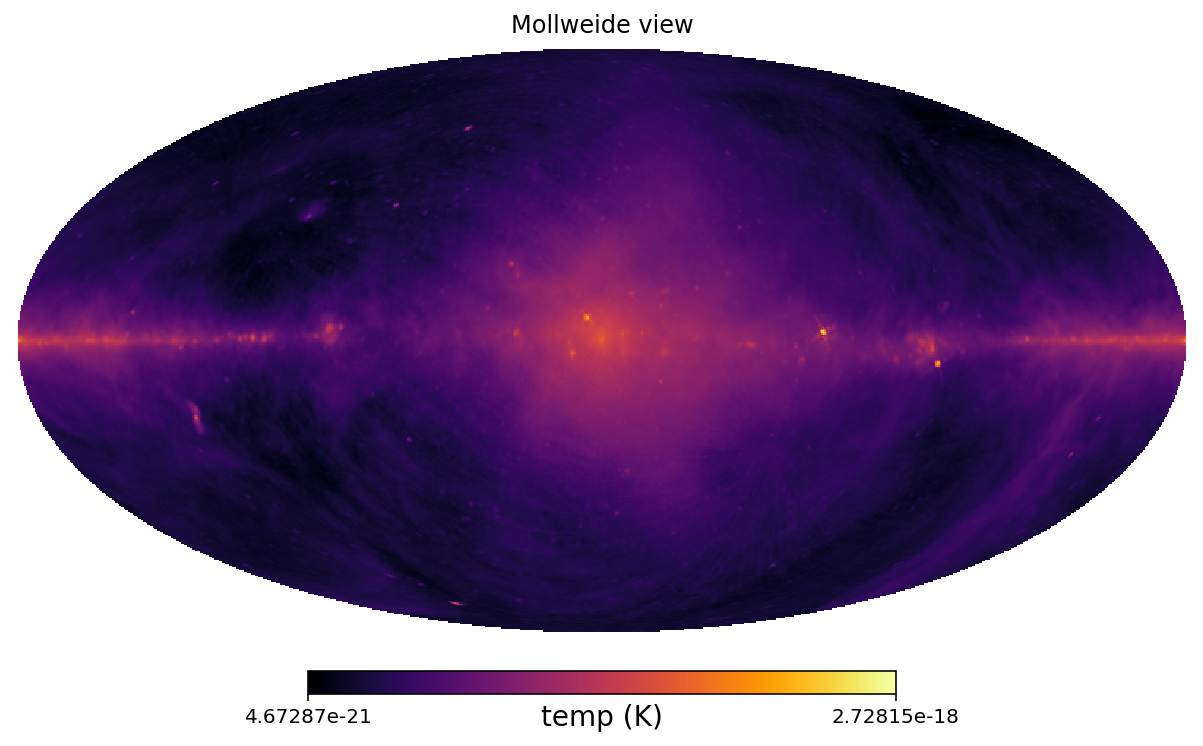

In [19]:
%%time
#testing gegesncheiner code
a = np.load("raw_maps/map_raw_50000000.0_Hz.npz")['arr_0']
b = gegenscheiner(a, 50000000.0)
hp.mollview(b, cmap='inferno', norm='log', unit='temp (K)')

In [26]:
#listing elements in the directory of raw maps
scaled_raw_maps = os.listdir('raw_maps/')
scaled_raw_maps.remove('.DS_Store')
scaled_raw_maps

['map_raw_1795918367_Hz.npz',
 'map_raw_2578571429_Hz.npz',
 'map_raw_1615306122_Hz.npz',
 'map_raw_290816327_Hz.npz',
 'map_raw_1013265306_Hz.npz',
 'map_raw_1494897959_Hz.npz',
 'map_raw_953061224_Hz.npz',
 'map_raw_712244898_Hz.npz',
 'map_raw_892857143_Hz.npz',
 'map_raw_1555102041_Hz.npz',
 'map_raw_2036734694_Hz.npz',
 'map_raw_50000000_Hz.npz',
 'map_raw_832653061_Hz.npz',
 'map_raw_2096938776_Hz.npz',
 'map_raw_2698979592_Hz.npz',
 'map_raw_2939795918_Hz.npz',
 'map_raw_2397959184_Hz.npz',
 'map_raw_170408163_Hz.npz',
 'map_raw_2157142857_Hz.npz',
 'map_raw_351020408_Hz.npz',
 'map_raw_411224490_Hz.npz',
 'map_raw_652040816_Hz.npz',
 'map_raw_1856122449_Hz.npz',
 'map_raw_1314285714_Hz.npz',
 'map_raw_531632653_Hz.npz',
 'map_raw_2638775510_Hz.npz',
 'map_raw_1254081633_Hz.npz',
 'map_raw_2819387755_Hz.npz',
 'map_raw_1675510204_Hz.npz',
 'map_raw_1133673469_Hz.npz',
 'map_raw_1193877551_Hz.npz',
 'map_raw_1374489796_Hz.npz',
 'map_raw_1976530612_Hz.npz',
 'map_raw_591836735_Hz

In [27]:
%%time
#making gegenschein for each scaled temperature map
for i in scaled_raw_maps:
    a = np.load("raw_maps/%s"%(i))['arr_0'] #loading in raw maps with frequency scaled
    freq = float(i.split('_')[2]) #getting frequency from filename
    b = gegenscheiner(a, freq)
    np.savez("gegenschein_maps/gegenschein_at_%f_Hz"%(freq), b)
    

CPU times: user 1h 22min 4s, sys: 13.7 s, total: 1h 22min 17s
Wall time: 1h 22min 20s


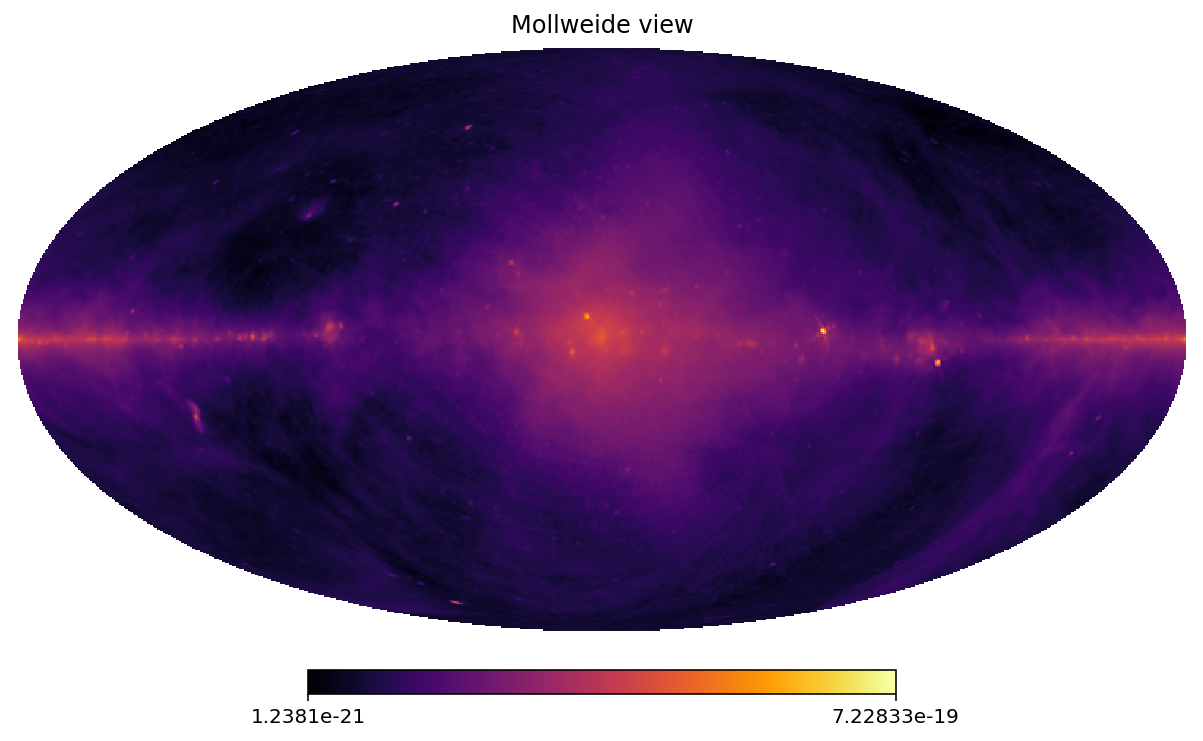

In [30]:
#testing gegenschein synchrotron maps at different frequencies
gegenschein_files = os.listdir('gegenschein_maps')
a = np.load("gegenschein_maps/gegenschein_at_712244898.000000_Hz.npz")['arr_0']
hp.mollview(a, norm='log', cmap='inferno')

# Now need to make maps that have the SNRs sprinkled on them

In [31]:
#testing out the SNR gegenschein and locations that I computed
np.load("SNRs/SNRs_at_3000000000.000000_Hz.npz")['arr_0']

array([[ 3.96317471e-24,  1.80000000e+02, -0.00000000e+00,
         2.82978492e+00],
       [ 9.09197935e-26,  1.80900000e+02, -1.00000000e-01,
         2.81677136e+00],
       [ 4.58806067e-29,  1.81900000e+02, -3.00000000e-01,
         2.66549048e+00],
       [ 4.48609958e-23,  1.86400000e+02,  1.00000000e-01,
         1.02857623e+01],
       [ 1.53692143e-26,  1.87700000e+02,  3.70000000e+00,
         3.48971927e+00],
       [ 1.20422872e-23,  1.88700000e+02,  1.00000000e-01,
         5.07586552e+00],
       [ 1.06798220e-25,  1.91200000e+02,  3.00000000e-01,
         2.77195341e+00],
       [ 1.77661624e-25,  1.95400000e+02, -1.00000000e-01,
         3.06301147e+00],
       [ 3.08814281e-26,  1.95900000e+02, -2.00000000e-01,
         2.75517901e+00],
       [ 2.37660398e-26,  1.96700000e+02, -1.00000000e-01,
         2.73057217e+00],
       [ 1.66818378e-25,  1.98100000e+02,  1.00000000e-01,
         3.13287869e+00],
       [ 1.37295740e-23,  1.98800000e+02, -3.00000000e-01,
      

In [32]:
# function that takes location, size, and intenisty of image and returns the indices to add to and the intensity to 
# add to each
def add_to_sky(shine, glon, glat, arcmin_radius, NSIDE):
    radian_radius = 2*(arcmin_radius/60)*(np.pi/180) #times 2 since Std Dev of a gaussian
    
    #making a normalized vector that points in the direction of gegenshcien to get a disk
    vec_0 = hp.ang2vec(glon, glat, lonlat=True)
    disk_points = hp.query_disc(NSIDE, vec = vec_0, radius = radian_radius, inclusive = True)
    
    num_pts = len(disk_points)
    tot_area = num_pts * hp.nside2pixarea(512)
    per_pixel_shine = shine/tot_area
    
    return([disk_points, per_pixel_shine])

In [33]:
def SNR_on_map(Ig_map, disk_points, per_pixel_shine):
    Ig_map[disk_points] += per_pixel_shine
    return(Ig_map)

In [34]:
#function that takes a map name and returns the map with SNRs added
def SNR_adder(name_Ig, name_SNRs):
    #loading in already generated data
    Ig_map = np.load("gegenschein_maps/%s"%(name_Ig))['arr_0']
    SNRs = np.load("SNRs/%s"%(name_SNRs))['arr_0']
    
    #looping over SNRs and putting them on sky map
    for i in SNRs:
        disk_points, per_pixel_shine = add_to_sky(i[0], i[1], i[2], i[3], 512)
        Ig_map = SNR_on_map(Ig_map, disk_points, per_pixel_shine)
    return(Ig_map)

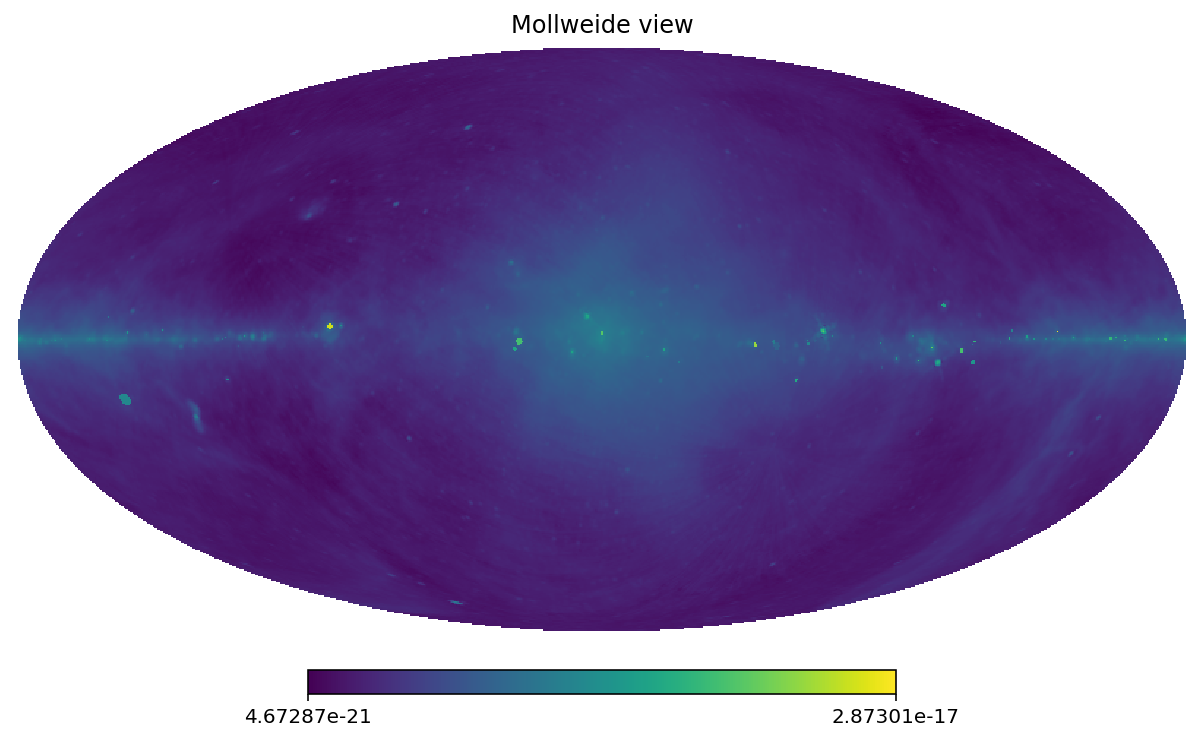

In [35]:
#testing above function
a = SNR_adder("gegenschein_at_50000000.000000_Hz.npz","SNRs_at_50000000.000000_Hz.npz")
hp.mollview(a, norm='log')

In [43]:
#cell that computes maps for each frequency and saves them
#sorting so that they corresposnd to each other
maps = np.sort(os.listdir('gegenschein_maps/'))
SNRs = np.sort(os.listdir('SNRs'))

#looping over these lists and making map of the combined SNR and synchrotron gegenschein
for i in range(len(maps)):
    a = SNR_adder(maps[i], SNRs[i])
    frequency = float(maps[i].split('_')[2])
    np.savez("snr_and_synchrotron/snr_and_synchrotron_at_%s_Hz"%(round(frequency)),a)

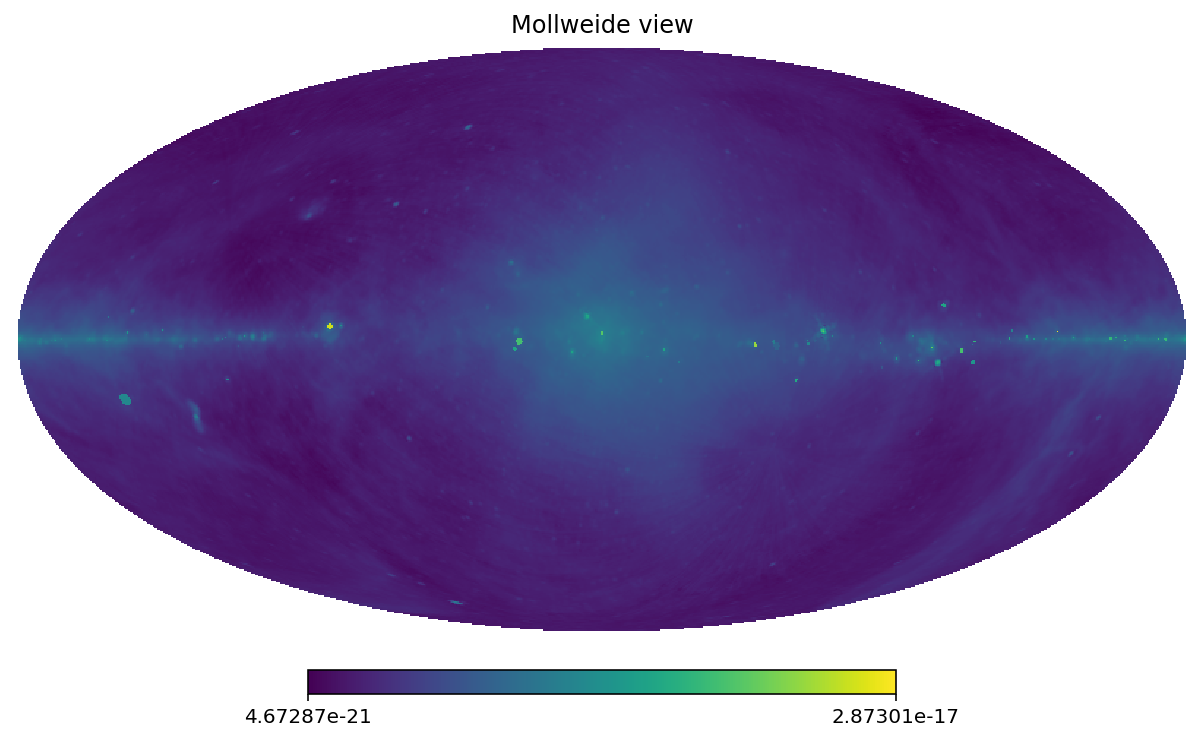

In [45]:
#testing previous cell
a = np.load("snr_and_synchrotron/snr_and_synchrotron_at_50000000_Hz.npz")['arr_0']
hp.mollview(a, norm='log')

In [38]:
hp.nside2npix(512)

3145728

In [49]:
%%time
#Need to loop over maps and produce masked maps for all of them (exclude area CHIME can't see)
mask_gal_map = np.load("mask_gal_map.npz")['arr_0']

#making boolean mask that can be used for calculation
field_of_view_mask = [True if i==1 else False for i in mask_gal_map]

frequencies = []
SN_ratio = []

#getting directory of SNR+synchrotron gegenschein and looping over it
maps = os.listdir('snr_and_synchrotron/')
for i in maps:
    #getting gegenschein map
    map_geg = np.load("snr_and_synchrotron/%s"%(i))['arr_0']
    
    frequency = i.split('_')[4]
    #need haslam raw map scaled to the proper frequency
    map_raw = np.load("raw_maps/map_raw_%s_Hz.npz"%(frequency))['arr_0']
    
    
    
    #masking the data with boolean mask to exclude area CHIME can't see
    Haslam_clipped = map_raw[field_of_view_mask]
    I_g_clipped = map_geg[field_of_view_mask]
    
    
    #now computing S/N ratio
    
    #getting signal power
    f_delta = 0.721
    eta_A = 0.5
    A_illu = 6.24e7 #cm^2
    beam_area = 0.0609235 #sr

    #computing signal power over sky
    signal_power = f_delta * eta_A * A_illu * I_g_clipped * beam_area
    
    #getting noise power
    #computing noise power per pixel for field of view
    k_b = 1.380649e-16 # Boltzmann's constant in cgs
    T_sys = 55 # K according to CHIME whitepaper
    #t_obs is probably wrong, I just need to know if it's time that that pixel is observed or total sky, for now 
    #doing total sky in absence of beam area information. assuming its been observing for 3.75 years, with data loss
    #of 69%
    t_obs = 265101.79 #in seconds, computed from total observing time and beam area and field of view size
    Delta_nu = 2.17 * (116000/299792458) * float(frequency) # using YK formula for delta nu

    #now implementing equation 23 with the Haslam map as T_sky
    noise_power = 2 * k_b * (T_sys + Haslam_clipped) * np.sqrt(Delta_nu/t_obs)
    
    SNR_sky = signal_power/noise_power
    
    #now computing SNR for 138 CHIMES covering the sky

    #to break sky up into 138 pieces will break the first 3141500 pixels which will divide into 206 evenly. 
    SNR_clipped = SNR_sky[:2110434]
    CHIMES = np.split(SNR_clipped, 138)

    #averaging over sky regions
    means = []
    for i in CHIMES:
        means.append(np.mean(i))

    #summing in quadrature
    total_SNR = np.sqrt(np.sum(np.array(means)**2))
    
    SN_ratio.append(total_SNR)
    frequencies.append(float(frequency))
    print("total_SNR: ", total_SNR, "at", frequency, " Hz")

total_SNR:  3.702992239872726 at 411224490  Hz
total_SNR:  3.6287175516059396 at 351020408  Hz
total_SNR:  3.3173086778169325 at 652040816  Hz
total_SNR:  1.4014905658155057 at 1976530612  Hz
total_SNR:  2.2228368971551977 at 170408163  Hz
total_SNR:  3.5826641350919557 at 531632653  Hz
total_SNR:  1.9544667792369936 at 1374489796  Hz
total_SNR:  2.2993748625432806 at 1133673469  Hz
total_SNR:  2.2039070110591488 at 1193877551  Hz
total_SNR:  1.6356992301506197 at 1675510204  Hz
total_SNR:  2.8873362333559753 at 832653061  Hz
total_SNR:  1.0606602941118553 at 2638775510  Hz
total_SNR:  2.1149171417842045 at 1254081633  Hz
total_SNR:  0.994063984645986 at 2819387755  Hz
total_SNR:  2.7544122659523644 at 892857143  Hz
total_SNR:  3.171529344221623 at 712244898  Hz
total_SNR:  2.62908470191129 at 953061224  Hz
total_SNR:  1.2237163543699692 at 2277551020  Hz
total_SNR:  1.193258003410181 at 2337755102  Hz
total_SNR:  0.9351844304992414 at 3000000000  Hz
total_SNR:  1.1101034427241971 at 2

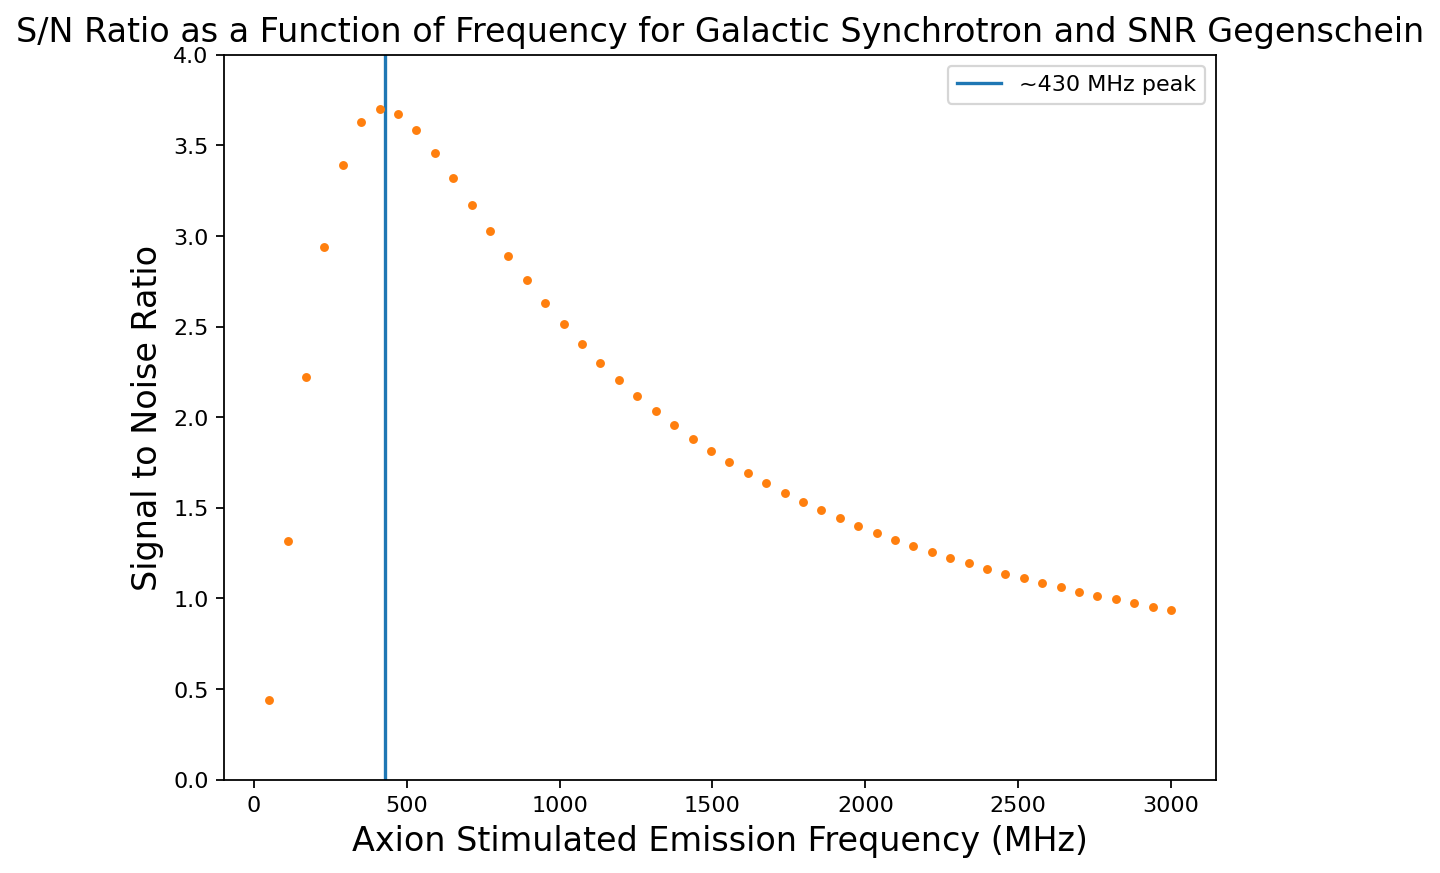

In [57]:
#plotting the S/N vs freq curve

plt.figure(figsize=(8, 6), dpi=80)


frequencies_rounded = [round(float(i)) for i in frequencies]
plt.plot([430, 430],[0, 4.3])
plt.plot(np.array(frequencies_rounded)/1e6, SN_ratio,'.')
plt.title('S/N Ratio as a Function of Frequency for Galactic Synchrotron and SNR Gegenschein', size = 15)
plt.xlabel("Axion Stimulated Emission Frequency (MHz)", size = 15)
plt.ylabel("Signal to Noise Ratio", size = 15)
plt.ylim([0,4.0])
plt.legend(['~430 MHz peak']);